# Hierarchical Clustering 

In [14]:
# Import Sparksession
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("Clustering").getOrCreate()

In [15]:
# Print PySpark and Python versions
import sys
print('Python version: '+sys.version)
print('Spark version: '+spark.version)

Python version: 3.8.4 | packaged by conda-forge | (default, Jul 17 2020, 15:16:46) 
[GCC 7.5.0]
Spark version: 3.0.0


## Load Data

In [16]:
# Read data
file_location = "cluster_data.csv"
file_type = "csv"
infer_schema = "false"
first_row_is_header = "true"


df = spark.read.format(file_type)\
.option("inferSchema", infer_schema)\
.option("header", first_row_is_header)\
.load(file_location)


In [17]:
# Print Metadata
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: string (nullable = true)
 |-- BALANCE_FREQUENCY: string (nullable = true)
 |-- PURCHASES: string (nullable = true)
 |-- ONEOFF_PURCHASES: string (nullable = true)
 |-- INSTALLMENTS_PURCHASES: string (nullable = true)
 |-- CASH_ADVANCE: string (nullable = true)
 |-- PURCHASES_FREQUENCY: string (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: string (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: string (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: string (nullable = true)
 |-- CASH_ADVANCE_TRX: string (nullable = true)
 |-- PURCHASES_TRX: string (nullable = true)
 |-- CREDIT_LIMIT: string (nullable = true)
 |-- PAYMENTS: string (nullable = true)
 |-- MINIMUM_PAYMENTS: string (nullable = true)
 |-- PRC_FULL_PAYMENT: string (nullable = true)
 |-- TENURE: string (nullable = true)



In [18]:
#  Count data
df.count()
print('The total number of records in the credit card dataset are '+str(df.count()))

The total number of records in the credit card dataset are 8950


# Casting variable to appropriate data types

In [19]:
# Casting multiple variables
from pyspark.sql.types import *

#Identifying and assiging lists of variables  
float_vars=list(set(df.columns) - set(['CUST_ID']))


for column in float_vars:
	df=df.withColumn(column,df[column].cast(FloatType()))


## Imputing the data

In [20]:
from pyspark.ml.feature import Imputer

# Shortlisting variables where mean imputation is required
input_cols=list(set(df.columns) - set(['CUST_ID']))

# Defining the imputer function
imputer = Imputer(
    inputCols=input_cols, 
    outputCols=["{}_imputed".format(c) for c in input_cols])

# Applying the transformation
df_imputed=imputer.fit(df).transform(df)

# Dropping the original columns as we created the _imputed columns
df_imputed=df_imputed.drop(*input_cols)

# Renaming the input columns to original columns for consistency
new_column_name_list= list(map(lambda x: x.replace("_imputed", ""), df.columns))
df_imputed = df_imputed.toDF(*new_column_name_list)


In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline

# Listing the variables that are not required in the segmentation analysis
ignore = ['CUST_ID']
# creating vector of all features
assembler = VectorAssembler(inputCols=[x for x in df.columns if x not in ignore],
                            outputCol='features')
# creating the normalization for all features for scaling betwen 0 to 1
normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)
# Defining the pipeline
pipeline = Pipeline(stages=[assembler, normalizer])
# Fitting the pipeline
transformations=pipeline.fit(df_imputed)
# Applying the transformation
df_updated = transformations.transform(df_imputed)


In [22]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(2).setSeed(1)
model = bkm.fit(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))

# Make predictions
predictions = model.transform(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.49855848955650006
Cluster Centers: 
[1.56899718e-02 1.07480745e-04 2.60570968e-02 9.19431713e-02
 4.12514135e-02 4.13338382e-02 4.21892243e-02 8.65430186e-05
 2.36687998e-03 1.49477386e-04 1.69572988e-03 6.73444143e-02
 6.69629544e-01 5.20146262e-05 2.03692023e-05 7.78368846e-05
 4.99429055e-06]
[9.87433798e-02 5.52450766e-05 4.51778189e-02 1.56153161e-01
 1.67613049e-01 3.68880540e-02 8.98395022e-02 4.07553710e-05
 1.58891509e-03 1.27041540e-04 1.35422759e-03 8.20154181e-02
 3.19911998e-01 1.37626105e-05 2.00523886e-05 4.36827025e-04
 2.07931012e-05]


# # Iterations

Silhouette with squared euclidean distance for 2 cluster solution = 0.49855848955650006
Silhouette with squared euclidean distance for 3 cluster solution = 0.47032306895494647
Silhouette with squared euclidean distance for 4 cluster solution = 0.36841230437497996
Silhouette with squared euclidean distance for 5 cluster solution = 0.35979911858435865
Silhouette with squared euclidean distance for 6 cluster solution = 0.3787940202378902
Silhouette with squared euclidean distance for 7 cluster solution = 0.3639517765678912


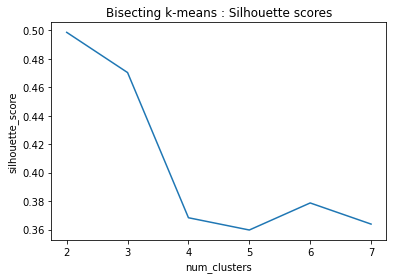

In [42]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

sil_coeff=[]
num_clusters=[]
for iter in range(2,8):
    bkm = BisectingKMeans().setK(iter).setSeed(1)
    model = bkm.fit(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))
    # Make predictions
    predictions = model.transform(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    sil_coeff.append(silhouette)
    num_clusters.append(iter)
    print("Silhouette with squared euclidean distance for "+str(iter) +" cluster solution = " + str(silhouette))
 

df_viz=pd.DataFrame(zip(num_clusters,sil_coeff), columns=['num_clusters','silhouette_score'])
sns.lineplot(x = "num_clusters", y = "silhouette_score", data=df_viz)
plt.title('Bisecting k-means : Silhouette scores')
plt.xticks(range(2, 8))
plt.show()